# Machine Learning model to predict the price of a property in Colombia

### The aim of this model is to predict wether a property in Colombia is expensive based on the price mean. If the price is less than the mean, the property is categorized as cheap. Otherwise it's categorized as expensive.

In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

In [18]:
import warnings
warnings.filterwarnings('ignore')

First, the train data is imported using Pandas library. There's one file for the training set and one for the test set.

In [19]:
df_train = pd.read_csv(os.path.join(os.getcwd(),'data','properties_colombia_train.csv'))

In [20]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197549 entries, 0 to 197548
Data columns (total 27 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       197549 non-null  int64  
 1   id               197549 non-null  object 
 2   ad_type          197549 non-null  object 
 3   start_date       197549 non-null  object 
 4   end_date         197549 non-null  object 
 5   created_on       197549 non-null  object 
 6   lat              148051 non-null  float64
 7   lon              148051 non-null  float64
 8   l1               197549 non-null  object 
 9   l2               197549 non-null  object 
 10  l3               186517 non-null  object 
 11  l4               45367 non-null   object 
 12  l5               27409 non-null   object 
 13  l6               6867 non-null    object 
 14  rooms            27537 non-null   float64
 15  bedrooms         40525 non-null   float64
 16  bathrooms        156467 non-null  floa

### Price

We can seee there are eight properties with USD currency.

In [21]:
df_train.groupby(df_train.currency).currency.count()

currency
COP    197474
USD         8
Name: currency, dtype: int64

The USD prices are converted to COP using information from the following web page.

https://freecurrencyrates.com/es/exchange-rate-history/USD-COP/2020/yahoo

In [6]:
df_train.price = np.where(df_train.currency == 'USD', df_train.price*4000 , df_train.price)

In [7]:
df_train.drop('currency',axis=1,inplace=True)

The price mean is calculated in order to know the value separating the two categories.

In [8]:
price_mean = df_train.price.mean()
print(price_mean)

645315583.7466555


If the price is less than the mean, the property price is converted to 0 (cheap). Otherwise it's converted to 1 (expensive).

In [9]:
df_train.price = df_train.price.apply(lambda x: 0 if x < price_mean else 1)

### Longitude and Latitude

Using geopandas we can check if the locations correspond to a place in Colombia as it should be.

In [10]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

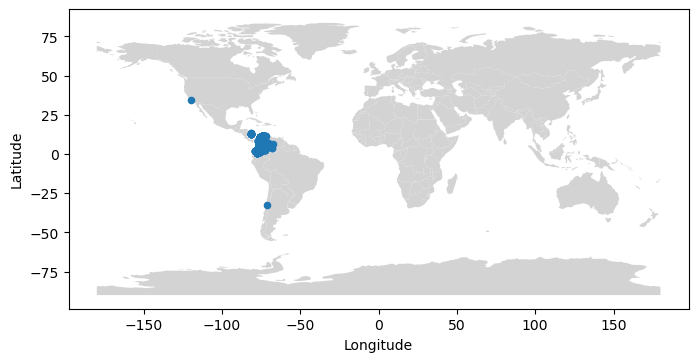

In [11]:
fig, ax = plt.subplots(figsize=(8,6))

countries.plot(color="lightgrey",ax=ax)

df_train.plot(x="lon", y="lat", kind="scatter",ax=ax)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


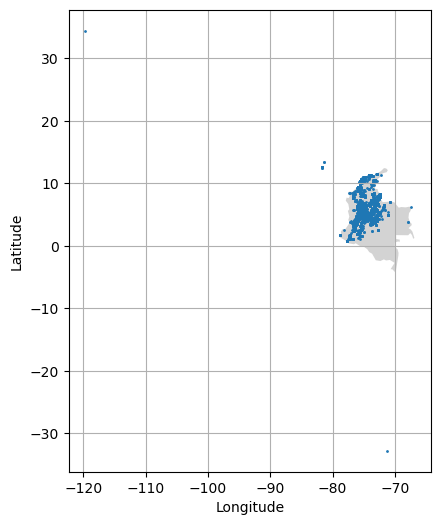

In [12]:
fig, ax = plt.subplots(figsize=(8,6))

countries[countries["name"] == "Colombia"].plot(color="lightgrey",ax=ax)

df_train.plot(x="lon", y="lat", kind="scatter",ax=ax,s=1)

ax.grid(alpha=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Some of the dots outside Colombia are located in 'San Andrés Providencia y Santa Catalina' so I keep those:

In [13]:
df_train[(df_train.lat > 10)&(df_train.lat <20)&(df_train.lon>-90)&(df_train.lon<-80)].l2.unique()


array(['San Andrés Providencia y Santa Catalina'], dtype=object)

The following data is not correct. The lonigutudes and latitudes do not correspond to Cudinamarca.

In [14]:
df_train[(df_train.lat>30)|(df_train.lat<-30)]

,Unnamed: 0,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,...,bathrooms,surface_total,surface_covered,price,price_period,title,description,property_type,operation_type,geometry
138682,172722,0xtrMhsbAsQiEv9XHGWTIQ==,Propiedad,2020-09-29,2021-07-26,2020-09-29,-32.787342,-71.20732,Colombia,Cundinamarca,...,6.0,NaN,NaN,1,NaN,51548 LA CALERA MIRADO DEL LAGO,"Casa hermosa,amplia, vigilancia sector&nbsp; t...",Casa,Venta,POINT (-71.20732 -32.787342)
148562,819292,s6bCv2RXRdHQGyS2+7WZ8Q==,Propiedad,2020-11-06,2021-07-26,2020-11-06,34.420334,-119.69819,Colombia,Cundinamarca,...,4.0,NaN,NaN,0,NaN,51599 SANTA BARBARA APARTAMENTO 506,"Apartamento&nbsp; para&nbsp; remodelar , duple...",Apartamento,Venta,POINT (-119.69819 34.420334)


In [15]:
df_train = df_train[(df_train.lat<30)&(df_train.lat>-30)]

The ***geometry*** column provides the same information as ***lat*** and ***lon***.<br>
The ***l1***, ***l2***, ***l3***, ***l4***, ***l5*** and ***l6*** columns are also related to the geographical location.<br>

In [16]:
df_train.drop(['geometry','l1','l2','l3','l4','l5','l6'],axis=1,inplace=True)

### Price period<br> Operation type<br> Ad type

In [17]:
print(df_train.price_period.unique())
print(df_train.operation_type.unique())
print(df_train.ad_type.unique())

[nan 'Mensual']
['Venta']
['Propiedad']


***operation_type***, ***price_period***, ***start_date***  do not provide useful information as they have only one value.


In [18]:
df_train.drop(['operation_type','price_period','ad_type'],axis=1,inplace=True)


***Unnamed***, ***id*** are not useful<br>
***start_date***, ***end_date*** and ***created_on*** have many wrong dates (year = 9999).<br>

In [19]:
df_train.drop(['Unnamed: 0','id','start_date','end_date','created_on'],axis=1,inplace=True)

In [20]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148049 entries, 0 to 197548
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   lat              148049 non-null  float64
 1   lon              148049 non-null  float64
 2   rooms            26988 non-null   float64
 3   bedrooms         37771 non-null   float64
 4   bathrooms        111190 non-null  float64
 5   surface_total    6504 non-null    float64
 6   surface_covered  9220 non-null    float64
 7   price            148049 non-null  int64  
 8   title            148048 non-null  object 
 9   description      147928 non-null  object 
 10  property_type    148049 non-null  object 
dtypes: float64(7), int64(1), object(3)
memory usage: 13.6+ MB


### Rooms<br> Bedrooms<br> Bathrooms<br>

There are many missing values in ***bathrooms***, ***bedrooms***, and ***rooms***. However, there may be some information about it in the description column.

I'll be using the nltk library to try to find those words in the description column of the dataset.

In [21]:
import nltk

In [22]:
from nltk.tokenize import word_tokenize
from collections import Counter

In [23]:
# nltk.download('all')

The description module is converted to a single string in order to find the most common words of the whole column.<br>
I'll check if our words of interest appear a significant amount of times.

In [24]:
all_text = df_train.description.str.cat(sep=" ").lower()

First, I'll look for words related to kind of rooms.<br>
We just want words that follow a number. (Example: 3 bathrooms)

In [25]:
import re
word_regex = '\d+\s\w+'
text = re.findall(word_regex,all_text)

In [26]:
text = ' '.join(text)

The strings are tokenized keeping stop words and numbers out.

In [27]:
tokens = [w for w in word_tokenize(text) if w.isalpha()]

In [28]:
from nltk.corpus import stopwords

In [29]:
no_stops = [t for t in tokens if t not in stopwords.words('spanish')]

Using Counter we can find the most common words.

In [30]:
from collections import Counter

In [31]:
Counter(no_stops).most_common(10)

[('habitaciones', 41121),
 ('baños', 34908),
 ('alcobas', 34660),
 ('horas', 18297),
 ('metros', 15468),
 ('baño', 11891),
 ('mts', 11369),
 ('millones', 9485),
 ('minutos', 8379),
 ('piso', 7720)]

We can see that the most common words are 'habitaciones', 'baños' (also appears in singular) and 'alcobas'. These words mean 'rooms', 'bathrooms' and 'bedrooms'.

Using the library ***re*** we can search for patterns. In this case I'll be searching for a pattern starting with a number following the words 'habitaciones', 'baño' or 'alcobas'.

I define some helper functions to get the numbers.

In [32]:
def get_number(room_kind,i):
    word_regex = '\d+\s' + room_kind
    try: 
        return float(re.search(word_regex,i).group(0).replace('\xa0',' ').replace('\n',' ').strip(' '+room_kind))
    except AttributeError:
        return float('NaN')
    except TypeError:
        return float('NaN')

In [33]:
def get_list_numbers(room_kind,df):
    list_numbers = []
    for i in df.description:
        list_numbers.append(get_number(room_kind,i))
    return list_numbers

The new information will be used to fill the missing values in bathrooms, rooms and bedrooms.

#### Rooms

In [34]:
df_train['rooms_2'] = get_list_numbers('habitaciones',df_train)
df_train.rooms.fillna(df_train.rooms_2,inplace=True)
df_train.drop('rooms_2',axis=1,inplace=True)

#### Bathrooms

In [35]:
df_train['bathrooms_2'] = get_list_numbers('baño',df_train)
df_train.bathrooms.fillna(df_train.bathrooms_2,inplace=True)
df_train.drop('bathrooms_2',axis=1,inplace=True)

#### Bedrooms

In [36]:
df_train['bedrooms_2'] = get_list_numbers('alcoba',df_train)
df_train.bedrooms.fillna(df_train.bedrooms_2,inplace=True)
df_train.drop('bedrooms_2',axis=1,inplace=True)

Now we have much more information about the number of bathrooms! I'll keep that column.

In [37]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148049 entries, 0 to 197548
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   lat              148049 non-null  float64
 1   lon              148049 non-null  float64
 2   rooms            49633 non-null   float64
 3   bedrooms         58407 non-null   float64
 4   bathrooms        118239 non-null  float64
 5   surface_total    6504 non-null    float64
 6   surface_covered  9220 non-null    float64
 7   price            148049 non-null  int64  
 8   title            148048 non-null  object 
 9   description      147928 non-null  object 
 10  property_type    148049 non-null  object 
dtypes: float64(7), int64(1), object(3)
memory usage: 13.6+ MB


In [38]:
df_train.drop(['title','description'],axis=1,inplace=True)

#### Correlation matrix

In [39]:
corr = df_train.corr()
corr.style.background_gradient(cmap='coolwarm')

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
lat,1.000000,0.355319,-0.034105,-0.070404,-0.063854,-0.014730,-0.002049,-0.021410
lon,0.355319,1.000000,-0.030688,-0.043402,-0.021927,0.009189,-0.005953,0.039655
rooms,-0.034105,-0.030688,1.000000,0.688367,0.347380,0.077949,0.046858,0.187918
bedrooms,-0.070404,-0.043402,0.688367,1.000000,0.459473,0.068680,0.041647,0.196024
bathrooms,-0.063854,-0.021927,0.347380,0.459473,1.000000,0.104331,0.052970,0.433892
surface_total,-0.014730,0.009189,0.077949,0.068680,0.104331,1.000000,0.693788,0.154569
surface_covered,-0.002049,-0.005953,0.046858,0.041647,0.052970,0.693788,1.000000,0.022578
price,-0.021410,0.039655,0.187918,0.196024,0.433892,0.154569,0.022578,1.000000


Rooms bedrooms, rooms and bathrooms are correlated.<br>
There's more data about bathrooms so I'll keep that column.

In [40]:
df_train.drop(['rooms','bedrooms'],axis=1,inplace=True)

### Property type

The categorical column property_type is not numerical so it should be encoded, otherwise the machine learning model won't work.

In [41]:
df_dummies = pd.get_dummies(df_train.property_type)
df_dummies.drop('Otro',axis=1,inplace=True)

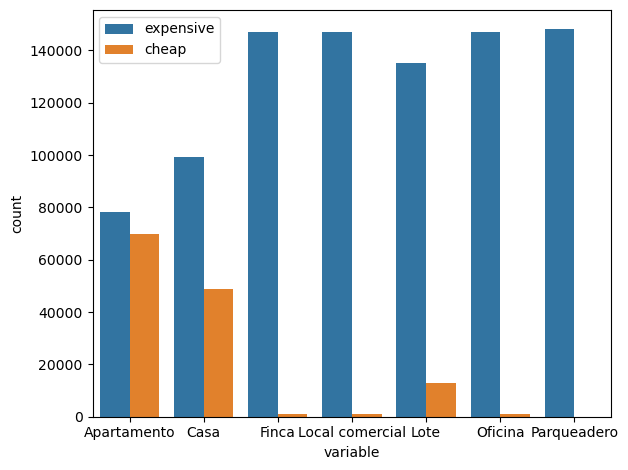

In [42]:
dfm = df_dummies.melt()
ax = sns.countplot(data=dfm, x='variable', hue='value')
ax.legend(labels=['expensive', 'cheap'])
plt.tight_layout()
plt.show()

This data won't be selected as features as it is highly imbalanced.

In [43]:
df_train.drop('property_type',axis=1,inplace=True)

### Pair plot

This pairplot shows that bathrooms, lat and lon are the best choice to be features.

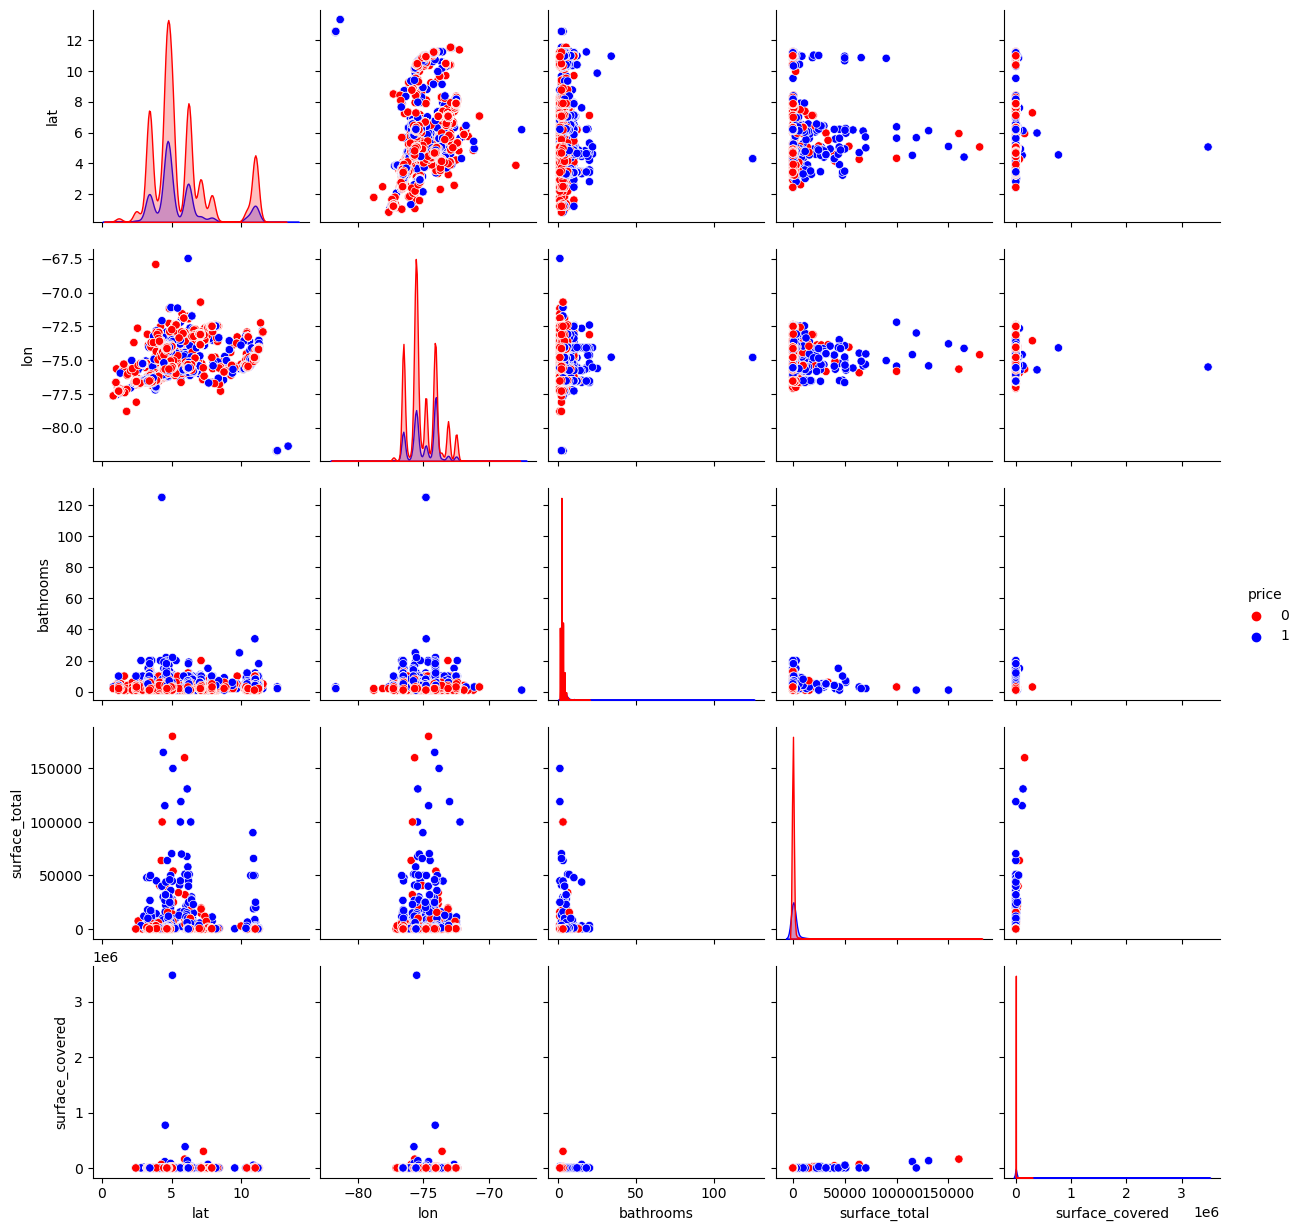

In [44]:
sns.pairplot(df_train, hue="price", palette = ['r', 'b', 'g'])
plt.show()

In [45]:
df_train.drop(['surface_total','surface_covered'],axis=1,inplace=True)

In [46]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148049 entries, 0 to 197548
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   lat        148049 non-null  float64
 1   lon        148049 non-null  float64
 2   bathrooms  118239 non-null  float64
 3   price      148049 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 5.6 MB


The missing values in bathrooms are filled with the mean.

In [47]:
df_train.bathrooms.fillna(df_train.bathrooms.mean(), inplace=True)

### Testing data

We also need to preprocess the test data. It should have the same amount of columns as the number of features.

In [48]:
df_test = pd.read_csv(os.path.join(os.getcwd(),'data','properties_colombia_test.csv'))

In [49]:
df_test.drop(['Unnamed: 0', 'id', 'ad_type', 'start_date', 'end_date', 'created_on',
       'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'rooms', 'bedrooms',
       'surface_total', 'surface_covered', 'currency',
       'price_period', 'title', 'property_type',
       'operation_type', 'geometry'],axis=1,inplace=True)

In [50]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65850 entries, 0 to 65849
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   lat          49433 non-null  float64
 1   lon          49433 non-null  float64
 2   bathrooms    52054 non-null  float64
 3   description  65823 non-null  object 
dtypes: float64(3), object(1)
memory usage: 2.0+ MB


In [51]:
df_test['bathrooms_2'] = get_list_numbers('baño',df_test)
df_test.bathrooms.fillna(df_test.bathrooms_2,inplace=True)
df_test.drop('bathrooms_2',axis=1,inplace=True)

In [52]:
df_test.drop('description',axis=1,inplace=True)

In [53]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65850 entries, 0 to 65849
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   lat        49433 non-null  float64
 1   lon        49433 non-null  float64
 2   bathrooms  54402 non-null  float64
dtypes: float64(3)
memory usage: 1.5 MB


In [54]:
df_test.lat.fillna(df_test.lat.mean(), inplace=True)
df_test.lon.fillna(df_test.lon.mean(), inplace=True)
df_test.bathrooms.fillna(df_test.bathrooms.mean(), inplace=True)

In [55]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65850 entries, 0 to 65849
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   lat        65850 non-null  float64
 1   lon        65850 non-null  float64
 2   bathrooms  65850 non-null  float64
dtypes: float64(3)
memory usage: 1.5 MB


## KNN

I implement a K-Nearest Neighbors algorithm to train the model and make the predictions.

#### Which number of neighbors should we use?


A model with a large number can cause underfitting as it's less able to detect relatioships in the dataset.<br>
On the other hand, a model with a model with a small number can be sensitive to noise in the training data, causing overfitting.

We can get an optimal number of neighbors by calculating the training and testing accuracy.<br>
A good choice would be when the testing and training set have similar accuracy or similar performance.

In [56]:
from sklearn.neighbors import KNeighborsClassifier

In [57]:
X = df_train.drop('price',axis=1).values  # features
y = df_train.price                        # target

In [58]:
print(X.shape,y.shape)

(148049, 3) (148049,)


I split the data into a train set and a test set.

In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=21, stratify=y)

I build several models using different number of neighbors.

In [61]:
train_accuracies = {}
test_accuracies = {}
neighbors = np.arange(1, 30)
for neighbor in neighbors:
    knn = KNeighborsClassifier(n_neighbors=neighbor)
    knn.fit(X_train, y_train)
    train_accuracies[neighbor] = knn.score(X_train, y_train)
    test_accuracies[neighbor] = knn.score(X_test, y_test)

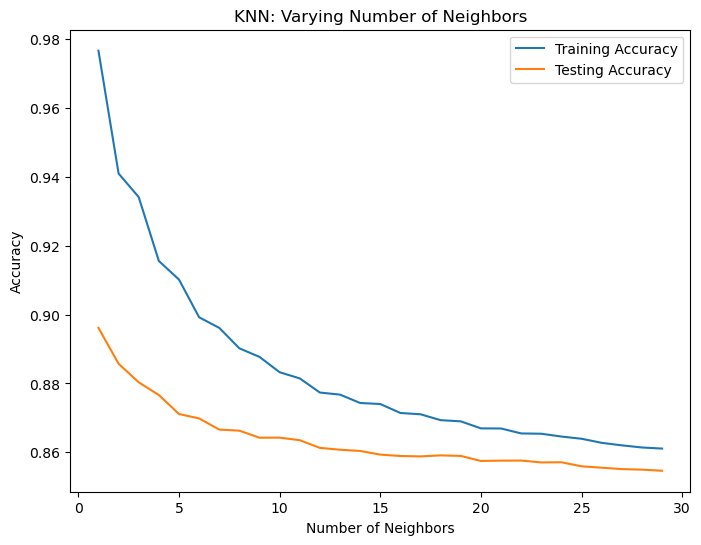

In [62]:
plt.figure(figsize=(8, 6))
plt.title("KNN: Varying Number of Neighbors")
plt.plot(neighbors, train_accuracies.values(), label="Training Accuracy")
plt.plot(neighbors, test_accuracies.values(), label="Testing Accuracy")
plt.legend()
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.show()

### Number of neighbors = 15

In [69]:
X_train = df_train.drop('price',axis=1).values  # features
y_train = df_train.price                        # target

In [70]:
clf = KNeighborsClassifier(n_neighbors=15)

In [71]:
clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=15)

In [72]:
y_pred = clf.predict(df_test.values)

In [73]:
pred = pd.DataFrame(data=y_pred,columns=['pred'])

In [74]:
pred.to_csv(os.path.join(os.getcwd(),'data','julicaro31.csv'),index=False)